In [ ]:
!pip install implicit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import implicit
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import scipy.sparse as sparse
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score,precision_recall_curve,roc_curve, auc, f1_score, roc_auc_score, precision_score, recall_score

     |████████████████████████████████| 1.1MB 3.9MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3406409 sha256=e0de4c3078775e4299fab4c0eac5f1528266a74705fad7d323b0912491b4431f
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


##**C Dataset**

In [ ]:
#Disease Features from heterogeneous network
dis_features = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/disease_feature.txt', header=None)
dis_features = dis_features.iloc[:,1:].values
dis_features.shape

(409, 1071)

In [ ]:
#Drug Features from heterogeneous network
drug_features = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/drug_feature.txt', header=None)
drug_features = drug_features.iloc[:,1:].values
drug_features.shape

(663, 1071)

In [ ]:
#Drug Disease Association Matrix
dda_mat = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/DiDrAMat.txt', sep = ' ', header=None)
dda_mat = dda_mat.values
dda_mat.shape

(409, 663)

In [ ]:
#Getting the train, validation and test datasets.
train = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/train.txt', sep=' ',header=None)
# drug_features = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/drug_feature.txt', header=None)
val = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/valid.txt', sep=' ',header=None)
test = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/test.txt', sep=' ',header=None)
final_data = pd.concat([train,val],ignore_index=True, sort=False)
# train.head(),val.head(),test.head()
final_data.head(),final_data.shape

(         0        1  2
 0  DB00125  D137215  0
 1  DB01099  D312910  0
 2  DB00271  D175100  0
 3  DB00624  D146850  1
 4  DB00211  D263300  0, (4557, 3))

In [ ]:
#Drug and Disease Features corresponding to their IDs
drug_f = dict()
with open('/content/drive/MyDrive/CF Dataset/CDataset/drug_feature.txt', 'r') as f:
    for line in f:
        drug_id, fp = line.strip().split()
        fp = np.array(fp.split(','), dtype='float32')
        drug_f[drug_id] = fp

disease_f = dict()
with open('/content/drive/MyDrive/CF Dataset/CDataset/disease_feature.txt', 'r') as f:
    for line in f:
        disease_id, md = line.strip().split()
        md = np.array(md.split(','), dtype='float32')
        disease_f[disease_id] = md

In [ ]:
#Giving a code to every drug and disease
drug_code={}
dis_code={}
i=0
for drug in drug_f.keys():
  drug_code[drug]=i
  i+=1
i=0
for dis in disease_f.keys():
  dis_code[dis]=i
  i+=1


In [ ]:
#10 Fold CV
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)


In [ ]:
n_drugs = np.unique(train.iloc[:,0].values).shape[0]
n_dis = np.unique(train.iloc[:,1].values).shape[0]
print(n_drugs, n_dis)
def get_data(data):
  """
  Function that returns all 4 components of data
  """
  train_drug = np.array([drug_code[d] for d in data.iloc[:,0].values])
  train_dis = np.array([dis_code[d] for d in data.iloc[:,1].values])
  train_drug_features = np.array([drug_f[d] for d in data.iloc[:,0].values])
  train_dis_features = np.array([disease_f[d] for d in data.iloc[:,1].values])
  return train_drug, train_dis, train_drug_features, train_dis_features
train_drug, train_dis, train_drug_features, train_dis_features = get_data(train)

663 409


In [ ]:
#Generalized Matrix Factorization
import torch
# define the class of GMF model
class GMF(torch.nn.Module):
    def __init__(self, n_drugs,n_dis,latent_dim=100):
        super(GMF, self).__init__()
        self.embedding_drug = torch.nn.Embedding(num_embeddings=n_drugs, embedding_dim=latent_dim)
        self.embedding_dis = torch.nn.Embedding(num_embeddings=n_dis, embedding_dim=latent_dim)
        # add the user and item bias
        self.drug_bias = nn.Embedding(n_drugs, 1)
        self.dis_bias = nn.Embedding(n_dis, 1)
        #uniform the embedding of user and item 
        self.embedding_drug.weight.data.uniform_(0,0.05)
        self.embedding_dis.weight.data.uniform_(0,0.05)
        self.drug_bias.weight.data.uniform_(-0.01,0.01)
        self.dis_bias.weight.data.uniform_(-0.01,0.01)
        self.affine_output = torch.nn.Linear(in_features=latent_dim, out_features=1)
        # set sigmoid function
        self.logistic = torch.nn.Sigmoid()


    def forward(self, user_indices, item_indices):
        drug_embedding = self.embedding_drug(user_indices)
        dis_embedding = self.embedding_dis(item_indices)
        dis_bias_mf = self.dis_bias(item_indices)
        drug_bias_mf = self.drug_bias(user_indices)
        element_product = torch.mul(drug_embedding, dis_embedding)
        element_product = element_product + dis_bias_mf+drug_bias_mf
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        # rating = logits
        return rating
        

In [ ]:
def train_epocs_gmf(model, epochs=10, lr=1e-3, wd=0.0, unsqueeze=False):
    loss_arr=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        # users = torch.LongTensor(train.iloc[:,0].values)#.cuda()
        # items = torch.LongTensor(train.iloc[:,1].values)#.cuda()
        users = torch.LongTensor(train_drug)
        items = torch.LongTensor(train_dis)
        ratings = torch.FloatTensor(train.iloc[:,2].values)#.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
        loss_arr.append(loss.item())
    # test_loss(model, unsqueeze)
    print('save')
    # save the weight of model
    torch.save(model.state_dict(), 'gmf_model.pt')
    plt.plot(loss_arr)
    plt.xlabel('epochs')
    plt.ylabel('MSE loss')
    plt.title('GMF')
    plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'GMF_MSE_Loss.png')



In [ ]:
gmf_model = GMF(n_drugs, n_dis)
train_epocs_gmf(gmf_model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)

In [ ]:
#Multi Layer Perceptron Model
class MLP(torch.nn.Module):
    def __init__(self, n_drugs,n_dis,latent_dim=32,layers=[64,32,16,8]):
        super(MLP, self).__init__()
        self.feature_size = train_dis_features.shape[1]
        self.embedding_drug = torch.nn.Linear(self.feature_size, latent_dim)
        self.embedding_dis = torch.nn.Linear(self.feature_size, latent_dim)
        self.drug_bias = nn.Embedding(n_drugs, 1)
        self.dis_bias = nn.Embedding(n_dis, 1)
        self.embedding_drug.weight.data.uniform_(0,0.05)
        self.embedding_dis.weight.data.uniform_(0,0.05)
        self.drug_bias.weight.data.uniform_(-0.01,0.01)
        self.dis_bias.weight.data.uniform_(-0.01,0.01)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
        self.affine_output = torch.nn.Linear(in_features=layers[-1], out_features=1)
        self.logistic = torch.nn.Sigmoid()
        # self.logistic = torch.nn.Softmax(dim=1)


    def forward(self, drug_features, dis_features):
        drug_embedding = self.embedding_drug(drug_features)
        dis_embedding = self.embedding_dis(dis_features)
        drug_embedding = F.dropout(drug_embedding, 0.1)
        dis_embedding = F.dropout(dis_embedding, 0.1)
        dis_bias_mlp = self.dis_bias(torch.LongTensor(train_dis))
        drug_bias_mlp = self.drug_bias(torch.LongTensor(train_drug))
        vector = torch.cat([drug_embedding, dis_embedding + dis_bias_mlp +  drug_bias_mlp], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            vector = F.dropout(vector, 0.1)

        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating




# define the train function
def train_epocs_mlp(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    loss_arr=[]
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        # users = torch.LongTensor(train[:,0])#.cuda()
        # items = torch.LongTensor(train[:,1])#.cuda()
        users = torch.Tensor(train_drug_features)
        items = torch.Tensor(train_dis_features)
        # print(users.size(), items.size())
        ratings = torch.FloatTensor(train.iloc[:,2].values)#.cuda()
        if unsqueeze:
            ratings = ratings.unsqueeze(1)
        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(loss.item()) 
        loss_arr.append(loss.item())
    # test_loss(model, unsqueeze)
    print('save')
    # save the model
    torch.save(model.state_dict(), 'mlp_model.pt')
    plt.plot(loss_arr)
    plt.xlabel('epochs')
    plt.ylabel('MSE loss')
    plt.title('MLP')
    plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'MLP_MSE_Loss.png')


In [ ]:
# build the mlp model
mlp_model = MLP(n_drugs, n_dis)#.cuda()



# train the model
#train_epocs_mlp(mlp_model, epochs=1000, lr=0.001, wd=1e-6, unsqueeze=True) #if use cuda the epochs could use 1000
train_epocs_mlp(mlp_model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)

In [ ]:
#Final Neural Matrix Factorization Model
class NeuMF(torch.nn.Module):
    def __init__(self, n_drugs, n_dis, latent_dim_mf=100, latent_dim_mlp=32, layers=[64,32,16,8]):
        super(NeuMF, self).__init__()

        # Part of GMF
        self.embedding_drug_mf = torch.nn.Embedding(num_embeddings=n_drugs, embedding_dim=latent_dim_mf)
        self.embedding_dis_mf = torch.nn.Embedding(num_embeddings=n_dis, embedding_dim=latent_dim_mf)
        self.embedding_drug_mf_bias = nn.Embedding(n_drugs, 1)
        self.embedding_dis_mf_bias = nn.Embedding(n_dis, 1)
        self.embedding_drug_mf_bias.weight.data.uniform_(-0.01,0.01)
        self.embedding_dis_mf_bias.weight.data.uniform_(-0.01,0.01)

        # Part of MLP
        self.feature_size = train_dis_features.shape[1]
        self.embedding_drug_mlp = torch.nn.Linear(self.feature_size, latent_dim_mlp)
        self.embedding_dis_mlp = torch.nn.Linear(self.feature_size, latent_dim_mlp)
        self.embedding_drug_mlp_bias = nn.Embedding(n_drugs, 1)
        self.embedding_dis_mlp_bias = nn.Embedding(n_dis, 1)
        self.embedding_drug_mlp_bias.weight.data.uniform_(-0.01,0.01)
        self.embedding_dis_mlp_bias.weight.data.uniform_(-0.01,0.01)
        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(layers[:-1], layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=layers[-1] + latent_dim_mf, out_features=1)
        self.logistic = torch.nn.Sigmoid()
        # self.logistic = torch.nn.Softmax(dim=1)

    def forward(self, user_indices, item_indices, drug_features, dis_features):

        # Part of GMF
        drug_embedding_mf = self.embedding_drug_mf(user_indices)
        dis_embedding_mf = self.embedding_dis_mf(item_indices)
        drug_embedding_mf = F.dropout(drug_embedding_mf, 0.1)
        dis_embedding_mf = F.dropout(dis_embedding_mf, 0.1)
        dis_bias_mf = self.embedding_dis_mf_bias(item_indices)
        drug_bias_mf = self.embedding_drug_mf_bias(user_indices)
        mf_vector =torch.mul(drug_embedding_mf, dis_embedding_mf)
        mf_vector = mf_vector + dis_bias_mf+drug_bias_mf
        
        # Part of MLP
        drug_embedding_mlp = self.embedding_drug_mlp(drug_features)
        dis_embedding_mlp = self.embedding_dis_mlp(dis_features)
        drug_embedding_mlp = F.dropout(drug_embedding_mlp, 0.1)
        dis_embedding_mlp = F.dropout(dis_embedding_mlp, 0.1)
        dis_bias_mlp = self.embedding_dis_mlp_bias(item_indices)
        drug_bias_mlp = self.embedding_drug_mlp_bias(user_indices)
        mlp_vector = torch.cat([drug_embedding_mlp, dis_embedding_mlp + dis_bias_mlp +  drug_bias_mlp], dim=-1)
        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)
            mlp_vector = F.dropout(mlp_vector, 0.1)

        # Fusion of GMF and MLP
        vector = torch.cat([F.dropout(mlp_vector,0.1), F.dropout(mf_vector,0.1)], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    # load the wieght from GMF model and MLP model
    def load_pretrain_weights(self):
        
        # Part of GMF
        gmf_model = GMF(n_drugs,n_dis,latent_dim=100)#.cuda()
        gmf_model.load_state_dict(torch.load('gmf_model.pt'))
        self.embedding_drug_mf.weight.data = gmf_model.embedding_drug.weight.data
        self.embedding_dis_mf.weight.data = gmf_model.embedding_dis.weight.data

        # Part of MLP
        mlp_model = MLP(n_drugs,n_dis,latent_dim=32,layers=[64,32,16,8])#.cuda()
        mlp_model.load_state_dict(torch.load('mlp_model.pt'))
        self.embedding_drug_mlp.weight.data = mlp_model.embedding_drug.weight.data
        self.embedding_dis_mlp.weight.data = mlp_model.embedding_dis.weight.data        
        for idx in range(len(self.fc_layers)):
            self.fc_layers[idx].weight.data = mlp_model.fc_layers[idx].weight.data
        
        # Concatenate weights of the two models.
        self.affine_output.weight.data = 0.5 * torch.cat([mlp_model.affine_output.weight.data, gmf_model.affine_output.weight.data], dim=-1)
        self.affine_output.bias.data = 0.5 * (mlp_model.affine_output.bias.data + gmf_model.affine_output.bias.data)

def test_loss(model, val_drug, val_dis, val_drug_features, val_dis_features, true_label):
    model.eval()
    ratings = torch.FloatTensor(true_label)#.cuda()
    test_users = torch.LongTensor(val_drug)#.cuda()
    test_items = torch.LongTensor(val_dis)#.cuda()
    test_drug_features = torch.Tensor(val_drug_features)
    test_dis_features = torch.Tensor(val_dis_features)
    y_hat = model(test_users, test_items, test_drug_features, test_dis_features)
    # print(y_hat)
    return roc_auc_score(true_label, np.round(y_hat.detach().numpy())),accuracy_score(true_label, np.round(y_hat.detach().numpy())), precision_score(true_label, np.round(y_hat.detach().numpy())) , recall_score(true_label, np.round(y_hat.detach().numpy())) ,f1_score(true_label, np.round(y_hat.detach().numpy())) 
    # loss = F.mse_loss(torch.round(y_hat), ratings)
    # print("test loss %.3f " % loss.item())

# define the train function
def train_epocs_NeuMF(model, epochs=10, lr=0.01, wd=0.0, unsqueeze=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    avg_auc = 0.0
    avg_acc = 0.0
    avg_prec = 0.0
    avg_recall = 0.0
    avg_f1 = 0.0
    print('test_auc, test_acc, test_prec, test_recall, test_f1')
    for train_ind, test_ind in kf.split(final_data):
        train_drug, train_dis, train_drug_features, train_dis_features = get_data(final_data.iloc[train_ind,:])
        val_drug, val_dis, val_drug_features, val_dis_features = get_data(final_data.iloc[test_ind,:])
        model = NeuMF(n_drugs, n_dis,layers=[64,32,16,8])#.cuda()
        model.load_pretrain_weights()
        model.train()
        loss_arr=[]
        for i in range(epochs):
            users = torch.LongTensor(train_drug)
            items = torch.LongTensor(train_dis)
            drugs = torch.Tensor(train_drug_features)
            dis = torch.Tensor(train_dis_features)
            ratings = torch.FloatTensor(final_data.iloc[train_ind,:].iloc[:,2].values)#.cuda()
            if unsqueeze:
                ratings = ratings.unsqueeze(1)
            y_hat = model(users, items, drugs,dis)
            loss = F.mse_loss(y_hat, ratings)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print(loss.item()) 
            loss_arr.append(loss.item())
        true_label = final_data.iloc[test_ind,:].iloc[:,2].values
        test_auc, test_acc, test_prec, test_recall, test_f1 = test_loss(model, val_drug, val_dis, val_drug_features, val_dis_features, true_label)
        avg_auc += test_auc
        avg_acc += test_acc
        avg_prec += test_prec
        avg_recall += test_recall
        avg_f1 += test_f1
        print(test_auc, test_acc, test_prec, test_recall, test_f1)
    print('Average')
    print(avg_auc/10,avg_acc/10,avg_prec/10,avg_recall/10,avg_f1/10)
    print('save')
    torch.save(NeuMF_model.state_dict(), 'NeuMF_model.pt')
    plt.plot(loss_arr)
    plt.xlabel('epochs')
    plt.ylabel('MSE loss')
    plt.title('NeuMF')
    plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'NeuMF_MSE_Loss.png')



# build the NeuMF model


In [ ]:
NeuMF_model = NeuMF(n_drugs, n_dis,layers=[64,32,16,8])#.cuda()


# load the pre-training models of GMF and MLP
NeuMF_model.load_pretrain_weights()


# train the model
#train_epocs_NeuMF(NeuMF_model, epochs=1500, lr=0.0001, wd=1e-6, unsqueeze=True) #if use cuda, the epochs could use 1500
train_epocs_NeuMF(NeuMF_model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)

**Final Result Compilation**

In [ ]:
NeuMF_model.eval()
with torch.no_grad():
    val_drug, val_dis, val_drug_features, val_dis_features = get_data(test)
    test_users = torch.LongTensor(val_drug)#.cuda()
    test_items = torch.LongTensor(val_dis)#.cuda()
    test_drug_features = torch.Tensor(val_drug_features)
    test_dis_features = torch.Tensor(val_dis_features)
    users = torch.LongTensor(train_drug)
    items = torch.LongTensor(train_dis)
    drugs = torch.Tensor(train_drug_features)
    dis = torch.Tensor(train_dis_features)
    y_hat_NeuMF = NeuMF_model(test_users, test_items, test_drug_features, test_dis_features)
    y_hat_NeuMF_train = NeuMF_model(users, items, drugs, dis)
    print(y_hat_NeuMF)
    print(y_hat_NeuMF_train)
    

tensor([[2.3969e-02],
        [8.6790e-01],
        [9.9029e-01],
        [5.3945e-01],
        [9.3414e-01],
        [3.9465e-01],
        [8.7194e-03],
        [1.0000e+00],
        [4.0979e-01],
        [9.1678e-01],
        [1.3464e-02],
        [1.0000e+00],
        [9.9364e-01],
        [9.9939e-01],
        [3.0264e-03],
        [7.0647e-01],
        [9.3530e-01],
        [9.9463e-01],
        [6.5437e-01],
        [1.8491e-04],
        [3.9194e-02],
        [5.4150e-02],
        [9.8275e-01],
        [3.6788e-01],
        [9.8269e-01],
        [1.7430e-01],
        [1.0000e+00],
        [9.5126e-01],
        [1.3658e-01],
        [8.4782e-01],
        [4.4912e-01],
        [9.2701e-01],
        [9.8268e-01],
        [9.4510e-01],
        [3.6514e-01],
        [6.9400e-03],
        [8.9498e-02],
        [1.5430e-03],
        [9.3101e-01],
        [1.0000e+00],
        [1.0000e+00],
        [1.0000e+00],
        [9.9542e-01],
        [8.0551e-01],
        [1.5271e-01],
        [4

In [ ]:
accuracy_score(np.round(y_hat_NeuMF.numpy()),test.iloc[:,2].values)

0.7988165680473372

In [ ]:
prec, recall, threshold = precision_recall_curve(val.iloc[:,2].values, y_hat_NeuMF.numpy())
lr_f1, lr_auc = f1_score(val.iloc[:,2].values, np.round(y_hat_NeuMF.numpy())), auc(recall, prec)
no_skill = len(val.iloc[:,2].values[val.iloc[:,2].values==1]) / len(val.iloc[:,2].values)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, prec, marker='.', label='NeuMF')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'precision_recall_curve.png')
print('F1 Score',lr_f1)
print('AUC', lr_auc)

ROC AUC Score 0.8321815304091642


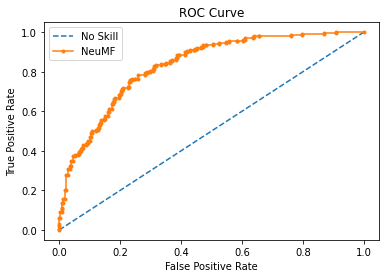

In [ ]:
fpr,tpr,_ = roc_curve(val.iloc[:,2].values, y_hat_NeuMF.numpy())
ns_probs = [0 for _ in range(len(val.iloc[:,2].values))]
ns_fpr, ns_tpr, _ = roc_curve(val.iloc[:,2].values, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='NeuMF')
lr_auc = roc_auc_score(val.iloc[:,2].values, y_hat_NeuMF.numpy())
# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'ROC_curve.png')
print('ROC AUC Score',lr_auc)

In [ ]:
from sklearn.metrics import classification_report
classification_report(test.iloc[:,2].values, np.round(y_hat_NeuMF.numpy()),output_dict=True)

{'0': {'f1-score': 0.7725321888412017,
  'precision': 0.8530805687203792,
  'recall': 0.7058823529411765,
  'support': 255},
 '1': {'f1-score': 0.8065693430656934,
  'precision': 0.7466216216216216,
  'recall': 0.876984126984127,
  'support': 252},
 'accuracy': 0.7909270216962525,
 'macro avg': {'f1-score': 0.7895507659534475,
  'precision': 0.7998510951710004,
  'recall': 0.7914332399626518,
  'support': 507},
 'weighted avg': {'f1-score': 0.7894500643137301,
  'precision': 0.8001660624701092,
  'recall': 0.7909270216962525,
  'support': 507}}

**Test Data Results**

In [ ]:
NeuMF_model.eval()
with torch.no_grad():
    test_users = torch.LongTensor(test_drug)#.cuda()
    test_items = torch.LongTensor(test_dis)#.cuda()
    test_drug_features = torch.Tensor(test_drug_features)
    test_dis_features = torch.Tensor(test_dis_features)
    users = torch.LongTensor(train_drug)
    items = torch.LongTensor(train_dis)
    drugs = torch.Tensor(train_drug_features)
    dis = torch.Tensor(train_dis_features)
    y_hat_NeuMF = NeuMF_model(test_users, test_items, test_drug_features, test_dis_features)
    y_hat_NeuMF_train = NeuMF_model(users, items, drugs, dis)
    print(y_hat_NeuMF)
    print(y_hat_NeuMF_train)
    # rating_NeuMF = [element.item() for element in y_hat_NeuMF.flatten()]
    # df_NeuMF=pd.DataFrame({'user_id':val_drug,'item_id':val_dis,'rating':rating_NeuMF})
    # # df_NeuMF_sort=df_NeuMF.sort_values(by=['user_id','rating'],ascending=[True,False])
    # final_NeuMF=df_NeuMF_sort.groupby('user_id').head(10)
    # final_NeuMF.to_csv('final_NeuMF.csv',index=False)
    # final_NeuMF=final_NeuMF.drop(columns=['rating'])
    

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy_score(np.round(y_hat_NeuMF.numpy()),test.iloc[:,2].values), accuracy_score(np.round(y_hat_NeuMF_train.numpy()),train.iloc[:,2].values)
accuracy_score(np.round(y_hat_NeuMF.numpy()),test.iloc[:,2].values)

0.7988165680473372

F1 Score 0.8145454545454546
AUC 0.836896064893032


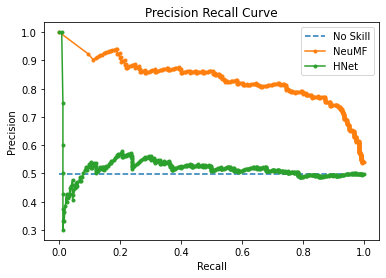

In [ ]:
prec, recall, threshold = precision_recall_curve(test.iloc[:,2].values, y_hat_NeuMF.numpy())
lr_f1, lr_auc = f1_score(test.iloc[:,2].values, np.round(y_hat_NeuMF.numpy())), auc(recall, prec)
no_skill = len(test.iloc[:,2].values[test.iloc[:,2].values==1]) / len(test.iloc[:,2].values)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, prec, marker='.', label='NeuMF')
prec, recall, threshold = precision_recall_curve(test.iloc[:,2].values, test_hnet)
plt.plot(recall, prec, marker='.', label='HNet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'precision_recall_curve_test.png')
print('F1 Score',lr_f1)
print('AUC', lr_auc)

ROC AUC Score 0.8638499844382197


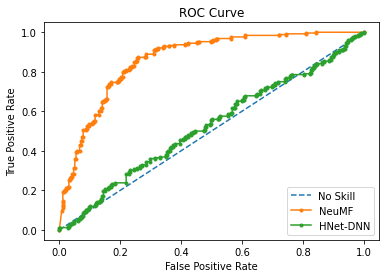

In [ ]:
fpr,tpr,_ = roc_curve(test.iloc[:,2].values, y_hat_NeuMF.numpy())
ns_probs = [0 for _ in range(len(test.iloc[:,2].values))]
ns_fpr, ns_tpr, _ = roc_curve(test.iloc[:,2].values, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='NeuMF')
fpr,tpr,_ = roc_curve(test.iloc[:,2].values, test_hnet)
plt.plot(fpr, tpr, marker='.', label='HNet-DNN')
lr_auc = roc_auc_score(test.iloc[:,2].values, y_hat_NeuMF.numpy())
# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'ROC_curve.png')
print('ROC AUC Score',lr_auc)

In [ ]:
test_hnet = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/result/y-HNet-DNN.txt', header=None)
test_hnet = test_hnet.values.ravel()
accuracy_score(test_hnet,test.iloc[:,2].values)

0.5226824457593688

ROC AUC Score 0.5249688764394647


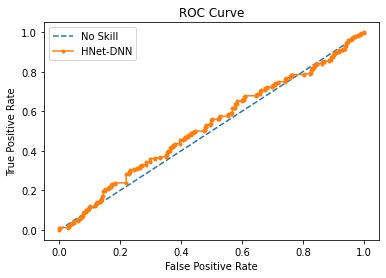

In [ ]:
test_hnet = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/result/probas1-HNet-DNN.txt', header=None)
test_hnet = test_hnet.values.ravel()
fpr,tpr,_ = roc_curve(test.iloc[:,2].values, test_hnet)
ns_probs = [0 for _ in range(len(test.iloc[:,2].values))]
ns_fpr, ns_tpr, _ = roc_curve(test.iloc[:,2].values, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='HNet-DNN')
lr_auc = roc_auc_score(test.iloc[:,2].values, test_hnet)
# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'ROC_curve.png')
print('ROC AUC Score',lr_auc)

In [ ]:
#stats of evaluation metrics
res = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/results_neumf.txt', sep=' ', header=None)
res.columns = ['AUC', 'Acuracy', 'Precision', 'Recall', 'F1 Score']
res.describe()

,AUC,Acuracy,Precision,Recall,F1 Score
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.903391,0.903201,0.866045,0.954036,0.907709
std,0.039595,0.040567,0.047833,0.030778,0.039154
min,0.795793,0.793407,0.746094,0.868182,0.802521
25%,0.903659,0.904605,0.858645,0.959057,0.910536
50%,0.911552,0.909989,0.869670,0.962118,0.912540
75%,0.923421,0.924890,0.897022,0.964324,0.931146
max,0.935362,0.934211,0.912214,0.974138,0.937255


##**PREDICT Dataset**

In [ ]:
#Disease Features from heterogeneous network
dis_features = pd.read_csv('/content/drive/MyDrive/CF Dataset/PREDICT/disease_feature.txt', header=None)
dis_features = dis_features.iloc[:,1:].values
dis_features.shape

(313, 905)

In [ ]:
#Drug Features from heterogeneous network
drug_features = pd.read_csv('/content/drive/MyDrive/CF Dataset/PREDICT/drug_feature.txt', header=None)
drug_features = drug_features.iloc[:,1:].values
drug_features.shape

(593, 905)

In [ ]:
#Drug Disease Association Matrix
dda_mat = pd.read_csv('/content/drive/MyDrive/CF Dataset/PREDICT/DiDrAMat', sep = ' ', header=None)
dda_mat = dda_mat.values
dda_mat.shape

(313, 593)

In [ ]:
#Getting the train, validation and test datasets.
train = pd.read_csv('/content/drive/MyDrive/CF Dataset/PREDICT/train.txt', sep=' ',header=None)
# drug_features = pd.read_csv('/content/drive/MyDrive/CF Dataset/CDataset/drug_feature.txt', header=None)
val = pd.read_csv('/content/drive/MyDrive/CF Dataset/PREDICT/valid.txt', sep=' ',header=None)
test = pd.read_csv('/content/drive/MyDrive/CF Dataset/PREDICT/test.txt', sep=' ',header=None)
final_data = pd.concat([train,val],ignore_index=True, sort=False)
# train.head(),val.head(),test.head()
final_data.head(),final_data.shape

(         0        1  2
 0  DB01174  D208085  1
 1  DB01151  D143465  1
 2  DB00252  D104130  1
 3  DB00637  D131200  0
 4  DB01427  D208750  0, (3478, 3))

In [ ]:
#Drug and Disease Features corresponding to their IDs
drug_f = dict()
with open('/content/drive/MyDrive/CF Dataset/PREDICT/drug_feature.txt', 'r') as f:
    for line in f:
        drug_id, fp = line.strip().split()
        fp = np.array(fp.split(','), dtype='float32')
        drug_f[drug_id] = fp

disease_f = dict()
with open('/content/drive/MyDrive/CF Dataset/PREDICT/disease_feature.txt', 'r') as f:
    for line in f:
        disease_id, md = line.strip().split()
        md = np.array(md.split(','), dtype='float32')
        disease_f[disease_id] = md

In [ ]:
#Giving a code to every drug and disease
drug_code={}
dis_code={}
i=0
for drug in drug_f.keys():
  drug_code[drug]=i
  i+=1
i=0
for dis in disease_f.keys():
  dis_code[dis]=i
  i+=1


In [ ]:
n_drugs = np.unique(train.iloc[:,0].values).shape[0]
n_dis = np.unique(train.iloc[:,1].values).shape[0]
print(n_drugs, n_dis)
def get_data(data):
  """
  Function that returns all 4 components of data
  """
  train_drug = np.array([drug_code[d] for d in data.iloc[:,0].values])
  train_dis = np.array([dis_code[d] for d in data.iloc[:,1].values])
  train_drug_features = np.array([drug_f[d] for d in data.iloc[:,0].values])
  train_dis_features = np.array([disease_f[d] for d in data.iloc[:,1].values])
  return train_drug, train_dis, train_drug_features, train_dis_features
train_drug, train_dis, train_drug_features, train_dis_features = get_data(train)

593 313


In [ ]:
#10 Fold CV
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)


0.25007352232933044
0.24997520446777344
0.24746334552764893
0.24236001074314117
0.23434802889823914
0.22375118732452393
0.21126146614551544
0.19792042672634125
0.18493644893169403
0.17334657907485962
0.1636190563440323
0.15559032559394836
0.14880897104740143
0.14285829663276672
0.13748186826705933
0.13254818320274353
0.1279730200767517
0.12367518991231918
0.11958878487348557
0.11567022651433945
0.11187533289194107
0.10815886408090591
0.10449164360761642
0.10086330026388168
0.09728682041168213
0.09379067271947861
0.09039699286222458
0.08711281418800354
0.08393577486276627
0.08085042983293533
0.07781989127397537
0.0748039111495018
0.07178370654582977
0.06876722723245621
0.06577534973621368
0.06283149123191833
0.05996779724955559
0.05721240118145943
0.054571352899074554
0.05204461142420769
0.04964534938335419
0.04742036759853363
0.04543237388134003
0.043710194528102875
0.04219783470034599
0.04083189368247986
0.039611563086509705
0.03855879232287407
0.037665240466594696
0.03688167408108711

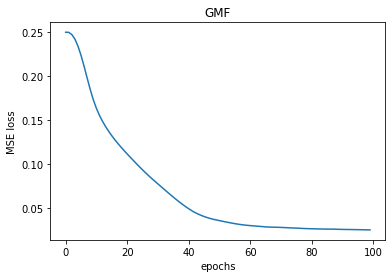

In [ ]:
gmf_model = GMF(n_drugs, n_dis)
train_epocs_gmf(gmf_model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)

0.258908212184906
0.25563135743141174
0.2542138397693634
0.2511845529079437
0.24819880723953247
0.24738048017024994
0.24328139424324036
0.23719008266925812
0.23305891454219818
0.22215774655342102
0.21283598244190216
0.20397669076919556
0.20701386034488678
0.19490262866020203
0.1906452775001526
0.18405656516551971
0.18545791506767273
0.17841145396232605
0.1733502894639969
0.1712004542350769
0.1686868965625763
0.16271796822547913
0.1646546721458435
0.1576666235923767
0.1564493179321289
0.15279650688171387
0.14693495631217957
0.14888818562030792
0.14376884698867798
0.1401924043893814
0.13832035660743713
0.13321459293365479
0.1374940425157547
0.12935619056224823
0.1285666674375534
0.13142460584640503
0.12248800694942474
0.12464876472949982
0.12020457535982132
0.11949760466814041
0.12132351845502853
0.11496831476688385
0.11395791918039322
0.11394345760345459
0.11095847189426422
0.10638470947742462
0.10710161179304123
0.10640902817249298
0.10731980204582214
0.1177346259355545
0.1320838928222

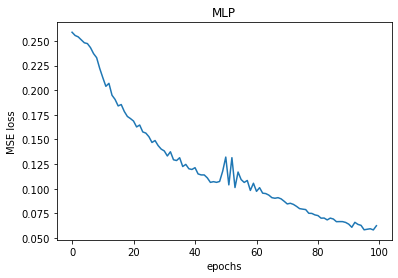

In [ ]:
# build the mlp model
mlp_model = MLP(n_drugs, n_dis)#.cuda()



# train the model
#train_epocs_mlp(mlp_model, epochs=1000, lr=0.001, wd=1e-6, unsqueeze=True) #if use cuda the epochs could use 1000
train_epocs_mlp(mlp_model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)

test_auc, test_acc, test_prec, test_recall, test_f1
0.8966473988439306 0.896551724137931 0.88268156424581 0.9132947976878613 0.8977272727272727
0.8924603174603175 0.8936781609195402 0.8743455497382199 0.9277777777777778 0.9002695417789757
0.9148037754595132 0.9166666666666666 0.8969072164948454 0.9508196721311475 0.923076923076923
0.9011425732737208 0.9022988505747126 0.8941798941798942 0.9234972677595629 0.9086021505376344
0.9430555555555556 0.9425287356321839 0.9252873563218391 0.9583333333333334 0.9415204678362572
0.9165671047391477 0.9137931034482759 0.8707865168539326 0.9567901234567902 0.911764705882353
0.8988150403813054 0.8994252873563219 0.8972972972972973 0.9120879120879121 0.9046321525885558
0.9056757928435656 0.9051724137931034 0.8827160493827161 0.910828025477707 0.8965517241379312
0.8757728874409946 0.8760806916426513 0.8729281767955801 0.8876404494382022 0.8802228412256268
0.7302972865123702 0.729106628242075 0.7010869565217391 0.7678571428571429 0.7329545454545454
Avera

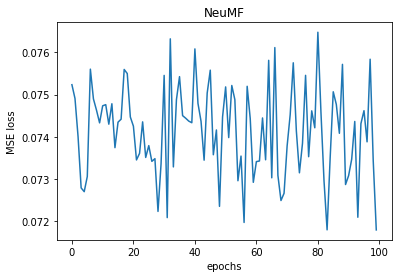

In [ ]:
NeuMF_model = NeuMF(n_drugs, n_dis,layers=[64,32,16,8])#.cuda()


# load the pre-training models of GMF and MLP
NeuMF_model.load_pretrain_weights()


# train the model
#train_epocs_NeuMF(NeuMF_model, epochs=1500, lr=0.0001, wd=1e-6, unsqueeze=True) #if use cuda, the epochs could use 1500
train_epocs_NeuMF(NeuMF_model, epochs=100, lr=0.01, wd=1e-6, unsqueeze=True)

In [ ]:
NeuMF_model.eval()
test_drug, test_dis, test_drug_features, test_dis_features = get_data(test)
with torch.no_grad():
    test_users = torch.LongTensor(test_drug)#.cuda()
    test_items = torch.LongTensor(test_dis)#.cuda()
    test_drug_features = torch.Tensor(test_drug_features)
    test_dis_features = torch.Tensor(test_dis_features)
    users = torch.LongTensor(train_drug)
    items = torch.LongTensor(train_dis)
    drugs = torch.Tensor(train_drug_features)
    dis = torch.Tensor(train_dis_features)
    y_hat_NeuMF = NeuMF_model(test_users, test_items, test_drug_features, test_dis_features)
    y_hat_NeuMF_train = NeuMF_model(users, items, drugs, dis)
    print(y_hat_NeuMF)
    print(y_hat_NeuMF_train)
    # rating_NeuMF = [element.item() for element in y_hat_NeuMF.flatten()]
    # df_NeuMF=pd.DataFrame({'user_id':val_drug,'item_id':val_dis,'rating':rating_NeuMF})
    # # df_NeuMF_sort=df_NeuMF.sort_values(by=['user_id','rating'],ascending=[True,False])
    # final_NeuMF=df_NeuMF_sort.groupby('user_id').head(10)
    # final_NeuMF.to_csv('final_NeuMF.csv',index=False)
    # final_NeuMF=final_NeuMF.drop(columns=['rating'])
    

tensor([[2.6846e-03],
        [9.5874e-01],
        [4.7137e-03],
        [3.1115e-01],
        [5.6431e-01],
        [8.9524e-01],
        [9.8473e-01],
        [9.2417e-01],
        [4.4528e-01],
        [9.9999e-01],
        [4.9514e-01],
        [3.8601e-01],
        [1.2249e-01],
        [3.2624e-01],
        [3.7469e-04],
        [1.6392e-02],
        [1.0210e-03],
        [2.4962e-01],
        [2.9916e-02],
        [9.8522e-01],
        [3.0266e-02],
        [9.0117e-01],
        [5.2110e-03],
        [1.2349e-01],
        [9.0625e-01],
        [9.4002e-01],
        [9.8592e-01],
        [3.4422e-01],
        [1.2524e-04],
        [9.1265e-01],
        [1.8087e-03],
        [9.0561e-01],
        [9.6617e-01],
        [2.7104e-05],
        [9.9360e-01],
        [9.9693e-01],
        [1.0000e+00],
        [9.9999e-01],
        [9.9493e-01],
        [9.2534e-01],
        [9.3912e-01],
        [1.5176e-02],
        [6.4118e-01],
        [5.5256e-01],
        [9.9994e-01],
        [2

In [ ]:
from sklearn.metrics import accuracy_score
# accuracy_score(np.round(y_hat_NeuMF.numpy()),test.iloc[:,2].values), accuracy_score(np.round(y_hat_NeuMF_train.numpy()),train.iloc[:,2].values)
accuracy_score(np.round(y_hat_NeuMF.numpy()),test.iloc[:,2].values)

0.7087628865979382

F1 Score 0.7237163814180929
AUC 0.804347960917011


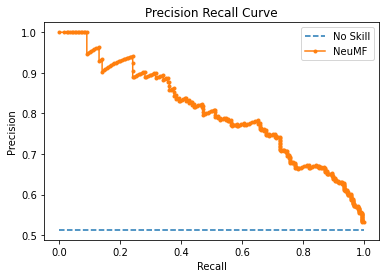

In [ ]:
prec, recall, threshold = precision_recall_curve(test.iloc[:,2].values, y_hat_NeuMF.numpy())
lr_f1, lr_auc = f1_score(test.iloc[:,2].values, np.round(y_hat_NeuMF.numpy())), auc(recall, prec)
no_skill = len(test.iloc[:,2].values[test.iloc[:,2].values==1]) / len(test.iloc[:,2].values)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, prec, marker='.', label='NeuMF')
# prec, recall, threshold = precision_recall_curve(test.iloc[:,2].values, test_hnet)
# plt.plot(recall, prec, marker='.', label='HNet')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'precision_recall_curve_test.png')
print('F1 Score',lr_f1)
print('AUC', lr_auc)

ROC AUC Score 0.795698067054851


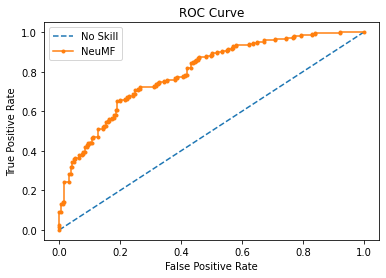

In [ ]:
fpr,tpr,_ = roc_curve(test.iloc[:,2].values, y_hat_NeuMF.numpy())
ns_probs = [0 for _ in range(len(test.iloc[:,2].values))]
ns_fpr, ns_tpr, _ = roc_curve(test.iloc[:,2].values, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='NeuMF')
# fpr,tpr,_ = roc_curve(test.iloc[:,2].values, test_hnet)
# plt.plot(fpr, tpr, marker='.', label='HNet-DNN')
lr_auc = roc_auc_score(test.iloc[:,2].values, y_hat_NeuMF.numpy())
# axis labels
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig('/content/drive/MyDrive/CF Dataset/Project Plots/'+'ROC_curve.png')
print('ROC AUC Score',lr_auc)

array([[0.      , 0.      , 0.      , ..., 0.093864, 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.018169, 0.10412 , 0.094949],
       ...,
       [0.      , 0.      , 0.      , ..., 0.017786, 0.      , 0.10211 ],
       [0.      , 0.      , 0.      , ..., 0.041078, 0.11758 , 0.10773 ],
       [0.      , 0.      , 0.      , ..., 0.023215, 0.066794, 0.060911]],
      dtype=float32)